In [8]:
## imports

import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

company_index='5'
company_name='Amazon'
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/'+f'{company_index}_{company_name}'
img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/LDA_vis'
img_flag = False

if not os.path.exists(img_path):
    os.makedirs(img_path)

In [9]:
## making dataset

def get_px_data(company_index=5, company_name='Amazon', uni=False, bi=False, tri=False):
    data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/'+f'{company_index}_{company_name}'+'/output_data/px_data2/pros.csv'
    df = pd.read_csv(data_path)
#     print(df.head())
    df_data = pd.DataFrame()
    df_data['Ratings'] = df['Ratings']
    df_data['Job_Status'] = df['Job_Status']
    df_data['Review_Text'] = df['Review_Text']
    if uni and bi and tri:
        df_data['Px_Texts'] = df['Unigrams'].fillna('') + ' ' + df['Bigrams'].fillna('') + ' ' + df['Trigrams'].fillna('')
    elif uni:
        df_data['Px_Texts'] = df['Unigrams'].dropna()
    elif bi:
        df_data['Px_Texts'] = df['Bigrams'].dropna()
    elif tri:
        df_data['Px_Texts'] = df['Trigrams'].dropna()
    
    return df_data
    
sentences = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=True, bi=True, tri=True)

# print(len(sentences))
# sentences[:5]
print(sentences.shape[0])
sentences.head()





14434


Ratings  Job_Status                                        Review_Text  \
0      5.0           0                   Free drinks, paid time, overtime   
1      5.0           0  On your own, flexible, can keep job even worki...   
2      1.0           0                                     Great benefits   
3      2.0           0                                             Safety   
4      4.0           0                                    Nice break room   

                                            Px_Texts  
0  drink free overtim paid time free_drink paid_t...  
1                   flexibl month time flexibl_time   
2                                          benefit    
3                                           safeti    
4                             break nice nice_break

In [10]:

def merge_data(company_list=[5], uni=False, bi=False, tri=False):
    sentences = []
    df_company_list = pd.read_csv( root + '/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/review_site.csv')
    sentences = pd.DataFrame(columns = ['Ratings', 'Job_Status', 'Review_Text', 'Px_Texts'])
    for company_index in company_list:
        company_name = df_company_list.iloc[company_index - 1]['Company_Name']
        px_sents = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri)
        if (px_sents.shape[0]) < 1000:
            sentences = pd.concat([sentences, px_sents], ignore_index=True)
        else:
            sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=42)], ignore_index=True)
    return sentences

# sentences = merge_data(company_list=[5],
#                         uni=True, bi=True, tri=True)
sentences = merge_data(company_list=range(1, 51),
                        uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=[5, 6, 7, 8, 9, 10],
#                         uni=True, bi=True, tri=True)
# print(len(sentences))
sentences.head()
sentences.to_csv('~/Desktop/R/1_50_1000_pros.csv')

In [42]:
tot = sentences.shape[0]
print(sentences[sentences.Job_Status == 1].shape[0]/tot)
print(sentences[sentences.Job_Status == 0].shape[0]/tot)


0.3008427227861067
0.6991572772138933


In [44]:
## tokenizing

sent_list = sentences[['Px_Texts']].values

data_px = []
for sent in sent_list:
    data_px.append(sent[0].split())
print(data_px)
sentences['Tokenized_Texts'] = data_px
sentences.head()

[['chang', 'constant', 'manag', 'rule', 'manag_chang'], ['hectic', 'time'], ['allow', 'hate', 'ot', 'rais'], ['associ', 'commun', 'manag', 'poor', 'commun_manag', 'manag_associ', 'manag_manag', 'poor_commun', 'poor_commun_manag'], ['bad', 'pay', 'bad_pay'], [], ['flexibl'], ['polici'], ['custom'], ['advanc', 'career', 'difficult'], ['horribl', 'hour', 'manag', 'poor', 'manag_horribl', 'poor_manag'], [], ['leav'], ['break', 'short', 'short_break'], ['attend', 'benefit', 'hold', 'hr', 'offer', 'polici', 'set', 'attend_polici'], ['busi', 'close', 'mistak'], ['mgr', 'pain'], ['none'], ['manag', 'unprofession', 'unprofession_manag'], ['none'], ['equal', 'especi', 'manag', 'move', 'posit'], ['employe', 'union'], ['manag', 'time', 'manag_time'], ['break', 'short', 'short_break'], ['middl', 'person', 'singl'], ['dont'], [], ['manag'], ['break', 'lunch', 'lunch_break'], ['associ', 'commun', 'manag', 'manag_commun'], ['bad', 'easili'], ['respect', 'suppos'], ['na'], ['arent', 'easi', 'handl', 'm

Ratings Job_Status                                        Review_Text  \
0      3.0          0      Constant management changes and rule changes.   
1      3.0          1                           Can get hectic at times.   
2      3.0          0                    They hate to allow raises or ot   
3      4.0          0  Poor communication between management, and fro...   
4      3.0          0                                            bad pay   

                                            Px_Texts  \
0             chang constant manag rule manag_chang    
1                                      hectic time     
2                               allow hate ot rais     
3  associ commun manag poor commun_manag manag_as...   
4                                   bad pay bad_pay    

                                     Tokenized_Texts  
0        [chang, constant, manag, rule, manag_chang]  
1                                     [hectic, time]  
2                            [allow, hate, ot, rais]  
3  [associ, commun, manag, poor, commun_manag, ma...  
4                                [bad, pay, bad_pay]

In [27]:
sentences.shape

(42956, 5)

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_px) ##dictionary
print(len(id2word))
print(id2word)

# Create Corpus
texts = data_px 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]  ##corpus

# View
# print(corpus[:1])
print(corpus[:5])

14990
Dictionary(14990 unique tokens: ['chang', 'constant', 'manag', 'manag_chang', 'rule']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1)], [(2, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1)]]


In [29]:
for i in range(14990):
    print(id2word[i])

chang
constant
manag
manag_chang
rule
hectic
time
allow
hate
ot
rais
associ
commun
commun_manag
manag_associ
manag_manag
poor
poor_commun
poor_commun_manag
bad
bad_pay
pay
flexibl
polici
custom
advanc
career
difficult
horribl
hour
manag_horribl
poor_manag
leav
break
short
short_break
attend
attend_polici
benefit
hold
hr
offer
set
busi
close
mistak
mgr
pain
none
unprofession
unprofession_manag
equal
especi
move
posit
employe
union
manag_time
middl
person
singl
dont
lunch
lunch_break
manag_commun
easili
respect
suppos
na
arent
easi
handl
bad_hour
ill
cut
fulltim
hour_cut
manag_poor
manag_skill
skill
time_manag
help
tell
tri
understand
holiday
bad_manag
recogn
promot
rare
loss
mandatori
overtim
peak
shift
slow
sometim
hire
market
outsid
prefer
hard
hard_time
feet
chanc
day
healthcar
littl
paid
partim
sick
sick_day
worker
stand
stand_day
ok
break_lunch
caus
lack
meal
time_break
violat
differ
quickli
due
speak
troubl
inconsist
inconsist_schedul
schedul
time_pay
rude
rude_custom
dog
eat
team

short_staf_time
staf_time
absolut
tie
downtim
time_person
district_manag
crew
skeleton
hour_welcom_season
welcom
welcom_season
tech_hour
hour_hour
hour_hour_cut
stand_time
benefit_low_wage
break_employe
short_break_employe
stress_manag
accomplish
schedual
lack_staff
littl_break
cut_hour_hour
pharmaci_manag
break_help
poor_manag_low
hour_minim
prioriti
break_low_wage
overwork_underpaid
short_break_overwork
custom_time
hour_avail
brother
minut_lunch_break
branch
daili_basi
oversight
sign
lunch_break_shift
skip
understaf_overwork
break_lack_hour
break_15_min
short_break_15
cafe
horrid
prescript
written
lowest
sneaki
rais_low
lunch_break_pay
break_feet_day
low_pay_lack
break_9_hour
similar
size
acknowledg
min_lunch_break
front_store
payrol
complic
modul
break_lot
overlap
certif
time_stress
hour_littl_pay
inept
constantli_cut
constantli_cut_hour
reactiv
lack_hour_poor
littl_pay_manag
short_break_staff
rph
short_break_unorgan
led
decreas
union_manag
desk_day
sit_desk_day
door_door
lack_life


chang_pay_structur
shift_holiday
balanc_unrealist
balanc_unrealist_expect
manag_worklif_balanc
worklif_balanc_quota
maryland
stress_retail_hour
statist
weekend_hour
rapidli
worklif_balanc_bad
cog
lot_stress
frontlin
minimum_wage_pay
wage_pay
breack
prais
dont_hour
advac
disciplinari
simpl
short_break_wage
sometim_short
sometim_short_break
groceri
low_pay_time
short_break_set
bagger
wage_manag
schedul_issu
fuel
pay_rate_manag
pay_union
low_pay_rais
battl
short_break_help
short_hour_low
kroger
interrupt
rude_employe
short_break_rais
hour_pay_low
employe_poor
set_hour
break_time_short
discourag
hour_low_wage
break_rude_manag
differ_hour
hard_break
hard_pay
break_8
break_8_hour
moodi
tip
littl_chanc_advanc
rais_manag
break_dont
poor_pay_poor
ratio
hour_minimum
hour_minimum_wage
short_break_minimum
underpay
pay_minimum
pay_minimum_wage
break_low_hour
bad_pay_bad
five
spous
benifet
break_sometim_break
neg_environ
short_break_busi
break_commun
short_break_commun
break_minimum_wage
peopl_short

minimum_benefit
real_secur
secur_bare
skeleton_crew
fourth
juli
shutdown_christma
purg
prevail
excel_benefit
clear_plan
lack_clear
canteen
limit_meal
menu
gutless
appeas
poor_execut
crd
tobacco
servicenev
hot_day
advers
habitu
lair
dowdupont
stakehold
tempcontract
anothert
employeess
edg
jbek
neither
rof
dow
influenc
conform
fad
sold_plant
wilmington
diplomat
didnot
biai
automat
textil
tho
managementshift
cancer
land
maid
advanc_cultur
csuit
rocket
master
aerotek
unemploy
burnt
beurocrat
uneccesari
stair
ofth
esh
acid
ceas
luch
final
sason
gate
restric
mostley
incllud
uncertain_futur
advoc
eviron
flip
dwind
oppritun
continuo
oportunidad
recort
slam
conseguir
difícil
permanencia
una
fool
altern
geographi
securirti
commin
harvest
commutegrowth
accountabilityfor
emmploye
polic
explos
concetr
er
clip
pleaselol
wazoo
overkil
exsit
disfunct
coordin
pioneer
repeat
health_insur_avail
stress_heavi
stress_heavi_workload
low_employe
low_employe_moral
bad_train
insur_polici
comfort_build_relations

isol_minim
lack_stimul
minim_interact
opportun_differ
posit_isol
stimul
stimul_opportun
incom_stream
inconsist_incom
stream
home_issu
type_worker
type_worker_hire
terribl_manag_structur
escrow
prudenti
benefit_option
lunch_benefit
decent_incom
earn_decent
adpat
paradigm
mentorship
balance
downward
spiral
bureaucraci_polit
kafkaesqu
kafkaesqu_bureaucraci
polit_insecur
abil_translat
abil_translat_success
translat
translat_success
manag_empathi
anymor_loyalti
anymor_loyalti_shame
loyalti_shame
none_peopl
none_peopl_anymor
peopl_anymor
peopl_anymor_loyalti
associ_ratio
heavi_manag_vs
manag_vs
manag_vs_associ
vs_associ
vs_associ_ratio
secur_iffi
complianc_depart
outsourc_complianc
outsourc_complianc_depart
bene
lull
residu
co_public
friendship
supersed
hierarchi_structur
hierarchi_structur_lot
lot_meet_bad
meet_bad
meet_bad_cultur
structur_lot
structur_lot_meet
corpor_polici
project_soon
annuiti
multilin
mutual
day_balanc
formal_inform
formal_inform_meet
inform_meet
inform_meet_requir
meet_

In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[('chang', 1),
  ('constant', 1),
  ('manag', 1),
  ('manag_chang', 1),
  ('rule', 1)],
 [('hectic', 1), ('time', 1)],
 [('allow', 1), ('hate', 1), ('ot', 1), ('rais', 1)],
 [('manag', 1),
  ('associ', 1),
  ('commun', 1),
  ('commun_manag', 1),
  ('manag_associ', 1),
  ('manag_manag', 1),
  ('poor', 1),
  ('poor_commun', 1),
  ('poor_commun_manag', 1)]]

In [35]:
# %%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
%time ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, iterations=500, random_seed=42)

CPU times: user 564 ms, sys: 17.2 ms, total: 581 ms
Wall time: 27 s


In [36]:
# Compute Coherence Score
%time coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_px, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 2.66 ms, sys: 2.35 ms, total: 5.01 ms
Wall time: 3.76 ms

Coherence Score:  0.33048696922153603


In [37]:
##mallet model to lda model conversion

optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [38]:
# %%time
# Visualize the topics
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='tsne')
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis
# pyLDAvis.show(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.040504 -0.112536       1        1  10.050460
1      0.018996 -0.178172       2        1  10.045051
2     -0.078329 -0.192750       3        1  10.031957
3      0.311351  0.125019       4        1  10.026174
7      0.348498 -0.008711       5        1  10.015652
6     -0.080743 -0.138596       6        1   9.998381
0     -0.087148 -0.078406       7        1   9.984681
8     -0.078360  0.297019       8        1   9.960720
4     -0.165128  0.256600       9        1   9.950187
5     -0.148632  0.030533      10        1   9.936735, topic_info=     Category         Freq         Term        Total  loglift  logprob
2     Default  5496.000000        manag  5496.000000  30.0000  30.0000
33    Default  3269.000000        break  3269.000000  29.0000  29.0000
34    Default  2511.000000        short  2511.000000  28.0000  28.0000
29    Default  3743.000000         hour  3743.000000  27.0000  27.0000
21    Default  2385.000000          pay  2385.000000  26.0000  26.0000
35    Default  1824.000000  short_break  1824.000000  25.0000  25.0000
25    Default  1582.000000       advanc  1582.000000  24.0000  24.0000
6     Default  2376.000000         time  2376.000000  23.0000  23.0000
16    Default  1305.000000         poor  1305.000000  22.0000  22.0000
118   Default  1234.000000         lack  1234.000000  21.0000  21.0000
300   Default  1135.000000       stress  1135.000000  20.0000  20.0000
55    Default  1132.000000      employe  1132.000000  19.0000  19.0000
150   Default  1124.000000          low  1124.000000  18.0000  18.0000
136   Default  1022.000000       balanc  1022.000000  17.0000  17.0000
38    Default  1205.000000      benefit  1205.000000  16.0000  16.0000
101   Default   914.000000         hard   914.000000  15.0000  15.0000
129   Default   908.000000      schedul   908.000000  14.0000  14.0000
0     Default   860.000000        chang   860.000000  13.0000  13.0000
94    Default   855.000000        shift   855.000000  12.0000  12.0000
62    Default   844.000000        lunch   844.000000  11.0000  11.0000
246   Default   773.000000          lot   773.000000  10.0000  10.0000
19    Default   767.000000          bad   767.000000   9.0000   9.0000
139   Default   749.000000         life   749.000000   8.0000   8.0000
24    Default   719.000000       custom   719.000000   7.0000   7.0000
105   Default  1022.000000          day  1022.000000   6.0000   6.0000
225   Default   691.000000      environ   691.000000   5.0000   5.0000
96    Default   596.000000      sometim   596.000000   4.0000   4.0000
151   Default   582.000000      low_pay   582.000000   3.0000   3.0000
31    Default   579.000000   poor_manag   579.000000   2.0000   2.0000
107   Default   569.000000        littl   569.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
213   Topic10   104.661060         free   104.661060   2.3089  -4.9221
765   Topic10   102.567839      distanc   102.567839   2.3089  -4.9423
1437  Topic10   101.521229        learn   101.521229   2.3089  -4.9526
44    Topic10   290.957748        close   294.113657   2.2981  -3.8996
894   Topic10    99.428007       perman    99.428007   2.3089  -4.9734
319   Topic10    96.288175         line    96.288175   2.3089  -5.0055
921   Topic10    95.241565        decis    95.241565   2.3089  -5.0164
156   Topic10   221.881448         fast   223.961429   2.2996  -4.1707
1309  Topic10    75.355963    atmospher    75.355963   2.3089  -5.2506
600   Topic10    70.122910         food    70.122910   2.3089  -5.3226
662   Topic10    59.656804  stress_time    59.656804   2.3089  -5.4842
1257  Topic10    53.377141        facil    53.377141   2.3089  -5.5954
596   Topic10    53.377141       hostil    53.377141   2.3089  -5.5954
563   Topic10    52.330530       orient    52.330530   2.3089  -5.6152
7108  Topic10    50.237309         bank    

In [670]:
#parameter tuning (finding the best model)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                 iterations=500, random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [671]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=2, limit=40, step=2)

KeyboardInterrupt: 

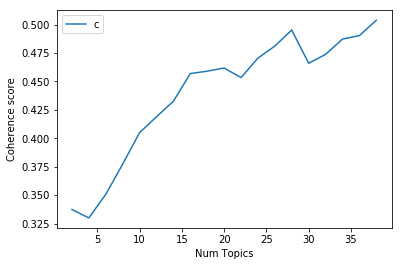

In [591]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
num_topics = 20
from collections import OrderedDict
def get_doc_topic_dist(model=optimal_model, corpus=corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys

top_dist, keys = get_doc_topic_dist(optimal_model, corpus, kwords=True)
print(top_dist[:5])
print(keys[:5])

[[0.04716981 0.04716981 0.04716981 0.04716981 0.04716981 0.10161072
  0.04716981 0.04716981 0.04716981 0.04717196 0.04716981 0.04716981
  0.04933052 0.04716981 0.04716981 0.04716981 0.04716981 0.04716981
  0.04716981 0.04716981]
 [0.04716981 0.04716981 0.04717975 0.04716981 0.04716981 0.04716981
  0.04716981 0.04716981 0.04716981 0.04719715 0.04716981 0.04716981
  0.04716981 0.10373632 0.04716981 0.04716981 0.04716981 0.04716981
  0.04716981 0.04716981]
 [0.08264121 0.04385965 0.04385965 0.04385965 0.04385965 0.04385965
  0.05178227 0.04385965 0.04385965 0.0438635  0.06130627 0.09648738
  0.04385965 0.04385965 0.04784186 0.04385965 0.04577692 0.04398481
  0.04385965 0.04385965]
 [0.04807692 0.04807692 0.04807692 0.04807692 0.04807692 0.04807692
  0.04807692 0.04807692 0.04807692 0.04807692 0.04807692 0.04807692
  0.04807692 0.05087756 0.04807692 0.04807692 0.04807692 0.04807692
  0.06450706 0.06730769]
 [0.04901961 0.04901961 0.04901961 0.04901961 0.04901961 0.0649422
  0.04901961 0.04

In [16]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

explore_topic(optimal_model, 0, 3)

lack                 0.157
manag                0.098
train                0.077


['lack', 'manag', 'train']

In [17]:
topic_summaries = []
num_topics = 20
# print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
#     print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(optimal_model,topic_number=i, topn=3, output=False )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print
    
print(topic_summaries)

# for t in topic_labels:
#     print(" ".join(t))
topic_label = [" ".join(t) for t in topic_summaries]
print(topic_label)

[['lack', 'manag', 'train'], ['advanc', 'opportun', 'littl'], ['stress', 'shift', 'environ'], ['lot', 'custom', 'peopl'], ['posit', 'secur', 'contract'], ['break', 'short', 'short_break'], ['manag', 'poor', 'poor_manag'], ['time', 'busi', 'salari'], ['con', 'polit', 'home'], ['hard', 'slow', 'promot'], ['hour', 'schedul', 'week'], ['pay', 'low', 'low_pay'], ['lunch', 'break', 'call'], ['employe', 'health', 'care'], ['manag', 'bad', 'team'], ['balanc', 'life', 'cultur'], ['manag', 'employe', 'dont'], ['time', 'sometim', 'move'], ['benefit', 'day', 'healthcar'], ['chang', 'overtim', 'layoff']]
['lack manag train', 'advanc opportun littl', 'stress shift environ', 'lot custom peopl', 'posit secur contract', 'break short short_break', 'manag poor poor_manag', 'time busi salari', 'con polit home', 'hard slow promot', 'hour schedul week', 'pay low low_pay', 'lunch break call', 'employe health care', 'manag bad team', 'balanc life cultur', 'manag employe dont', 'time sometim move', 'benefit da

In [18]:
top_labels = dict()

for i in range(num_topics):
    top_labels[i] = topic_label[i]
    
print(top_labels)

{0: 'lack manag train', 1: 'advanc opportun littl', 2: 'stress shift environ', 3: 'lot custom peopl', 4: 'posit secur contract', 5: 'break short short_break', 6: 'manag poor poor_manag', 7: 'time busi salari', 8: 'con polit home', 9: 'hard slow promot', 10: 'hour schedul week', 11: 'pay low low_pay', 12: 'lunch break call', 13: 'employe health care', 14: 'manag bad team', 15: 'balanc life cultur', 16: 'manag employe dont', 17: 'time sometim move', 18: 'benefit day healthcar', 19: 'chang overtim layoff'}


In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(
#                             analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

# display(sentences[['Px_Texts']].values.tolist())
sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
# display(sents)
# display(sentences[['Px_Texts']].values)
data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm
print(data_vectorized[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = CountVectorizer()

# sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
# data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm
# print(data_vectorized[:5])


In [20]:
top_dist, lda_keys= get_doc_topic_dist(optimal_model, corpus, True)
features = vectorizer.get_feature_names()
print(len(features))

14887


In [36]:
print(len(top_dist))
threshold = 0.07
# threshold = 1/num_topics
_idx = np.amax(top_dist, axis=1) > threshold  # idx of doc that above the threshold
X_topic = top_dist[_idx]
print(len(X_topic))
print(X_topic.shape)
print(X_topic)

43071
19545
(19545, 20)
[[0.04716981 0.04716981 0.04716981 ... 0.04716981 0.04716981 0.04716981]
 [0.04716981 0.04716981 0.04717974 ... 0.04716981 0.04716981 0.04716981]
 [0.08263608 0.04385965 0.04385965 ... 0.04398481 0.04385965 0.04385965]
 ...
 [0.04545455 0.04545455 0.04545455 ... 0.04545455 0.05732494 0.04545455]
 [0.04836931 0.04545455 0.04545455 ... 0.04545455 0.04545455 0.04545455]
 [0.04716981 0.04716981 0.04716981 ... 0.04716981 0.04716981 0.04716981]]


In [37]:
dtm = data_vectorized

In [38]:
p_df = pd.DataFrame()
p_df['tokenz'] = np.asarray(data_px)[_idx]
p_df.head()

tokenz
0                        [break, short, short_break]
1                        [care, health, health_care]
2  [inconsist, low, manag, pay, support, low_pay,...
3  [commun, lack, manag, poor, lack_commun, manag...
4               [day, manag, terribl, terribl_manag]

In [39]:
display(dtm)
print(p_df.shape)
print(len(X_topic))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(19545, 1)
19545


In [40]:
sentences[['Review_Text']].values

array([['Short Breaks'],
       ['no health care'],
       ['low pay, inconsistent support from management.'],
       ...,
       ['none'],
       ['breaks are not very flexible'],
       ['You must know how to play the corporate game or you will find yourself out the door.']],
      dtype=object)

In [41]:
top_ws = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]    
    top_ws += [' '.join(tmp)]


p_df['Text_Rep'] = pd.DataFrame(np.asarray(top_ws)[_idx])
p_df['clusters'] = pd.DataFrame(np.asarray(lda_keys)[_idx])
print(p_df['clusters'].isna().sum())
p_df['clusters'].fillna(20, inplace=True)
p_df['Review_Text'] = pd.DataFrame(sentences[['Review_Text']].values[_idx])
# p_df['Review_Text'] = sentences['Review_Text'].ix[_idx]


colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

cluster_colors = dict()
for c in range(num_topics): 
    cluster_colors[c] = colormap[c]
    
print(cluster_colors)
# cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 
#                   7:'maroon', 8:'crimson', 9:'black', 10:'gray', 11: '#8c564b'}

p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])





0
{0: '#1f77b4', 1: '#aec7e8', 2: '#ff7f0e', 3: '#ffbb78', 4: '#2ca02c', 5: '#98df8a', 6: '#d62728', 7: '#ff9896', 8: '#9467bd', 9: '#c5b0d5', 10: '#8c564b', 11: '#c49c94', 12: '#e377c2', 13: '#f7b6d2', 14: '#7f7f7f', 15: '#c7c7c7', 16: '#bcbd22', 17: '#dbdb8d', 18: '#17becf', 19: '#9edae5'}


In [42]:
p_df.shape

(19545, 5)

In [43]:
from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

X_tsne = tsne.fit_transform(X_topic)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19545 samples in 0.014s...
[t-SNE] Computed neighbors for 19545 samples in 10.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19545
[t-SNE] Computed conditional probabilities for sample 2000 / 19545
[t-SNE] Computed conditional probabilities for sample 3000 / 19545
[t-SNE] Computed conditional probabilities for sample 4000 / 19545
[t-SNE] Computed conditional probabilities for sample 5000 / 19545
[t-SNE] Computed conditional probabilities for sample 6000 / 19545
[t-SNE] Computed conditional probabilities for sample 7000 / 19545
[t-SNE] Computed conditional probabilities for sample 8000 / 19545
[t-SNE] Computed conditional probabilities for sample 9000 / 19545
[t-SNE] Computed conditional probabilities for sample 10000 / 19545
[t-SNE] Computed conditional probabilities for sample 11000 / 19545
[t-SNE] Computed conditional probabilities for sample 12000 / 19545
[t-SNE] Computed conditional probabilities for sa

In [44]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]
len(X_tsne[:, 0])

19545

In [45]:
display(p_df.head())
# print(p_df.shape)
print(p_df.iloc[4]['Review_Text'])

tokenz  \
0                        [break, short, short_break]   
1                        [care, health, health_care]   
2  [inconsist, low, manag, pay, support, low_pay,...   
3  [commun, lack, manag, poor, lack_commun, manag...   
4               [day, manag, terribl, terribl_manag]   

                                            Text_Rep  clusters  \
0                         short_break short break él         5   
1                         health_care care health él        13   
2            support_manag inconsist support low_pay        11   
3  poor_manag_lack manag_lack_commun lack_commun ...         0   
4                    terribl_manag terribl day manag         1   

                                         Review_Text   colors     X_tsne  \
0                                       Short Breaks  #98df8a  58.501328   
1                                     no health care  #f7b6d2  28.104456   
2     low pay, inconsistent support from management.  #c49c94  -8.954167   
3  poor management on something, lack of communic...  #1f77b4 -64.551399   
4  Modern day slavery, terrible management, simpl...  #aec7e8 -21.603413   

      Y_tsne  
0  -1.759101  
1 -42.996296  
2 -66.865448  
3   7.545401  
4 -29.624628

Modern day slavery, terrible management, simpleton work


In [46]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [47]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= p_df['clusters'],
    content = p_df['tokenz'],
    review_text = p_df['Review_Text']
))

In [48]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "KeyWords: @content <br> ReviewText: @review_text <br> Topic: @label "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/clustering/cons'
save(plot_lda, img_path+'/cluster4.html')

/anaconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/anaconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/Users/bishalsainju/Desktop/workspace/indeed/Job-Satisfaction/img/companies/clustering/cons/cluster4.html'